In [1]:
import zipfile
import os
import requests
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def download_zip(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            file.write(response.content)
    except Exception as e:
        print(f"Gagal mengunduh file: {e}")

def unzip_and_summarize(zip_path, extract_to='extracted_files'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    extracted_files = os.listdir(extract_to)

url = 'https://www.dropbox.com/sh/q5a07l8yynlgwa7/AADwJykQfJLSSRZsfzLh2ylsa?dl=1'
zip_path = 'dataset.zip'
download_zip(url, zip_path)
unzip_and_summarize(zip_path)

In [3]:
zip_file = 'dataset.zip'
csv_file = 'attendance.csv'
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        if csv_file in z.namelist():
            with z.open(csv_file) as f:
                df = pd.read_csv(f)
                df.fillna(method='ffill', inplace=True)
                stats = df.describe().T[['min', 'max', 'mean', '50%']]  # 50% adalah median
                stats['median'] = stats['50%']
                stats = stats[['min', 'max', 'mean', 'median']]
                summary = {
                    'Nama Variabel': df.columns,
                    'Deskripsi': ["Kode tim", "Nama tim", "Tahun", "Total kehadiran sepanjang musim", "Kehadiran di pertandingan kandang", "Kehadiran di pertandingan tandang", "Pekan Pertandingan", "Kehadiran mingguan"],
                    'Tipe Data': df.dtypes.values,
                    'Statistik Ringkas': [
                        f"Unik: {df[col].nunique()}" if df[col].dtype == 'object' else
                        f"min: {stats.loc[col, 'min']}<br>max: {stats.loc[col, 'max']}<br>mean: {stats.loc[col, 'mean']:.2f}<br>median: {stats.loc[col, 'median']:.2f}"
                        for col in df.columns
                    ]
                }
                summary_df = pd.DataFrame(summary)
                html_table = summary_df.to_html(index=False, escape=False, border=1,
                                                justify='center', classes='table table-striped table-bordered', render_links=True)

                display(HTML(f"<style>.table {{border-collapse: collapse;}} .table td, .table th {{border: 1px solid black; padding: 8px; text-align: center;}}</style>{html_table}"))
        else:
            print(f"{csv_file} tidak ditemukan di dalam {zip_file}")
except FileNotFoundError:
    print(f"File {zip_file} tidak ditemukan.")
except Exception as e:
    print("Terjadi kesalahan:", e)

<ipython-input-3-d1d850bd5928>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Nama Variabel,Deskripsi,Tipe Data,Statistik Ringkas
team,Kode tim,object,Unik: 32
team_name,Nama tim,object,Unik: 32
year,Tahun,int64,min: 2000.0max: 2019.0mean: 2009.53median: 2010.00
total,Total kehadiran sepanjang musim,int64,min: 760644.0max: 1322087.0mean: 1080910.03median: 1081089.50
home,Kehadiran di pertandingan kandang,int64,min: 202687.0max: 741775.0mean: 540455.01median: 543185.00
away,Kehadiran di pertandingan tandang,int64,min: 450295.0max: 601655.0mean: 540455.01median: 541757.00
week,Pekan Pertandingan,int64,min: 1.0max: 17.0mean: 9.00median: 9.00
weekly_attendance,Kehadiran mingguan,float64,min: 23127.0max: 105121.0mean: 67656.27median: 68388.50


Pre-processing

Cek missing value, gunanya untuk cek apakah ada data yang hilang, ini dilakukan untuk mencegah bias atau hasil analisis yang salah

In [4]:
print("Jumlah missing value per kolom:")
print(df.isnull().sum())

Jumlah missing value per kolom:
team                 0
team_name            0
year                 0
total                0
home                 0
away                 0
week                 0
weekly_attendance    0
dtype: int64


In [5]:
df

,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0
2,Arizona,Cardinals,2000,893926,387475,506451,3,66009.0
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0
...,...,...,...,...,...,...,...,...
10841,Washington,Redskins,2019,1101466,523906,577560,13,71504.0
10842,Washington,Redskins,2019,1101466,523906,577560,14,77296.0
10843,Washington,Redskins,2019,1101466,523906,577560,15,63246.0
10844,Washington,Redskins,2019,1101466,523906,577560,16,66083.0


In [6]:
df['daily_attendance'] = df['weekly_attendance'] / 7
df

,team,team_name,year,total,home,away,week,weekly_attendance,daily_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0,11062.000000
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0,9429.857143
2,Arizona,Cardinals,2000,893926,387475,506451,3,66009.0,9429.857143
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0,10257.285714
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0,9569.285714
...,...,...,...,...,...,...,...,...,...
10841,Washington,Redskins,2019,1101466,523906,577560,13,71504.0,10214.857143
10842,Washington,Redskins,2019,1101466,523906,577560,14,77296.0,11042.285714
10843,Washington,Redskins,2019,1101466,523906,577560,15,63246.0,9035.142857
10844,Washington,Redskins,2019,1101466,523906,577560,16,66083.0,9440.428571


Melihat daftar 10 tim terbaik, menggunakan variabel baru yang dibuat (daily_attendance)




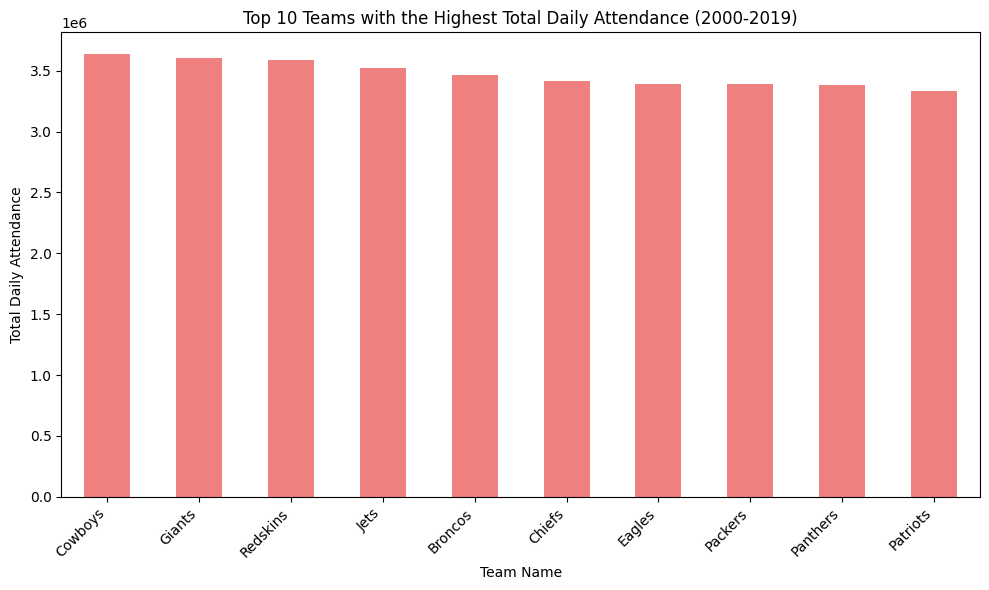

In [7]:
filtered_df = df[(df['year'] >= 2000) & (df['year'] <= 2019)]

total_daily_attendance = (
    filtered_df.groupby('team_name')['daily_attendance']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
total_daily_attendance.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Teams with the Highest Total Daily Attendance (2000-2019)')
plt.xlabel('Team Name')
plt.ylabel('Total Daily Attendance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Dari variabel home dan away, perbandingan kedua variabel dilakukan untuk melihat lebih popular mana permainan tim di kandang atau di tandang

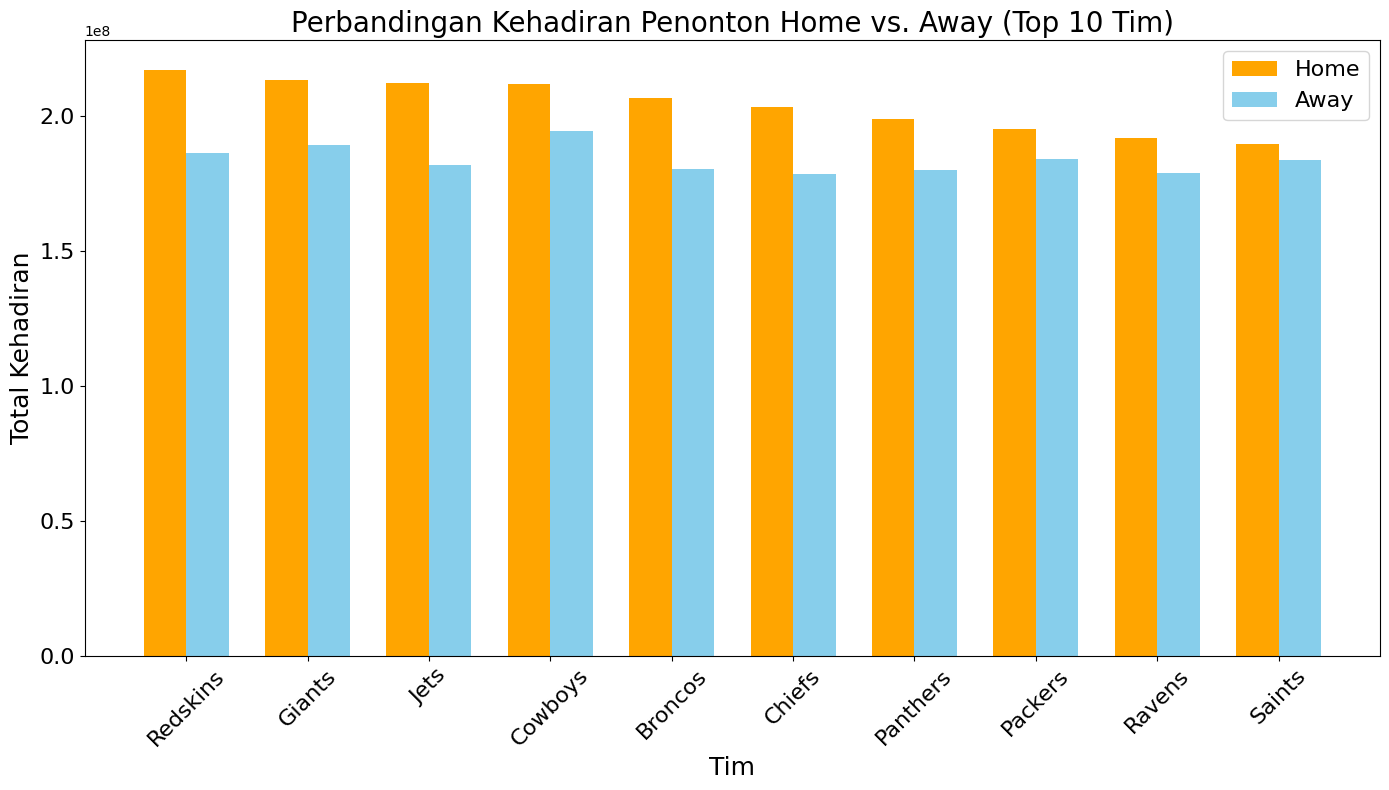

In [8]:
team_comparison = df.groupby('team_name')[['home', 'away']].sum()
team_comparison = team_comparison.sort_values(by='home', ascending=False).head(10)

plt.figure(figsize=(14, 8))
x = team_comparison.index
bar_width = 0.35
bar_home = team_comparison['home']
bar_away = team_comparison['away']
x_idx = range(len(x))

plt.bar(x_idx, bar_home, bar_width, label='Home', color='orange')
plt.bar([p + bar_width for p in x_idx], bar_away, bar_width, label='Away', color='skyblue')

plt.xlabel('Tim', fontsize=18)
plt.ylabel('Total Kehadiran', fontsize=18)
plt.title('Perbandingan Kehadiran Penonton Home vs. Away (Top 10 Tim)', fontsize=20)
plt.xticks([p + bar_width / 2 for p in x_idx], x, rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

Membuat grafik linechart tren kehadiran penonton, untuk melihat pola kepopularitasan tim di sepanjang tahun NFL (2000-2019)

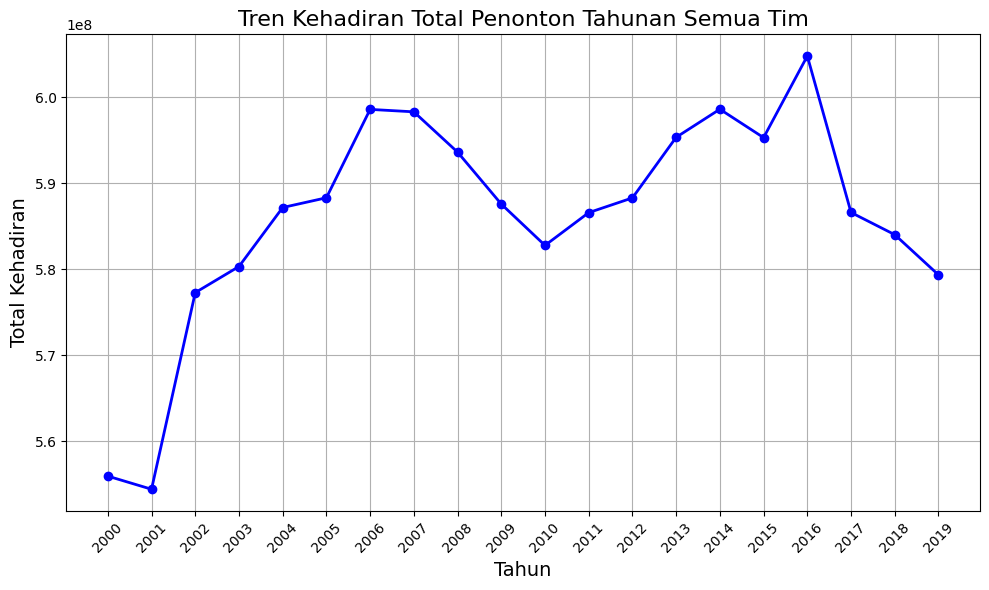

In [9]:
attendance_by_year = df.groupby('year')['total'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(attendance_by_year['year'], attendance_by_year['total'], marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Tren Kehadiran Total Penonton Tahunan Semua Tim', fontsize=16)
plt.xlabel('Tahun', fontsize=14)
plt.ylabel('Total Kehadiran', fontsize=14)
plt.grid(True)
plt.xticks(attendance_by_year['year'], rotation=45)
plt.tight_layout()
plt.show()

Membuat grafik 10 top tim di awal tahun data liga NFL (2000), untuk melihat 10 top tim pertama

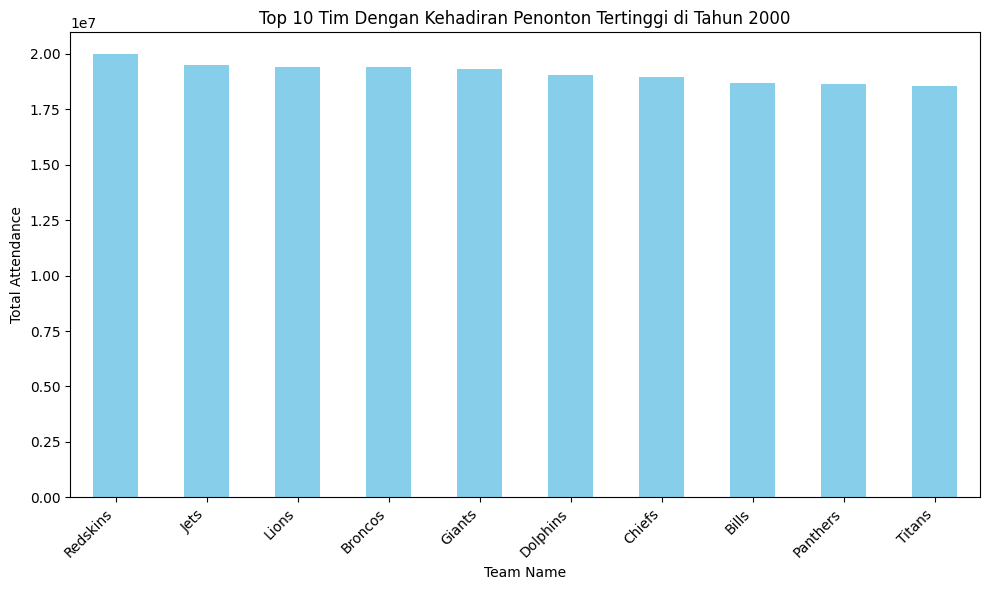

In [10]:
df_2001 = df[df['year'] == 2000]
top_10_teams = df_2001.groupby('team_name')['total'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_teams.plot(kind='bar', color='skyblue')
plt.title('Top 10 Tim Dengan Kehadiran Penonton Tertinggi di Tahun 2000')
plt.xlabel('Team Name')
plt.ylabel('Total Attendance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Dari grafik line chart sebelumnya, dibuatlah grafik untuk melihat 10 top tim di tahun dengan kehadiran penonton terendah sepanjang liga

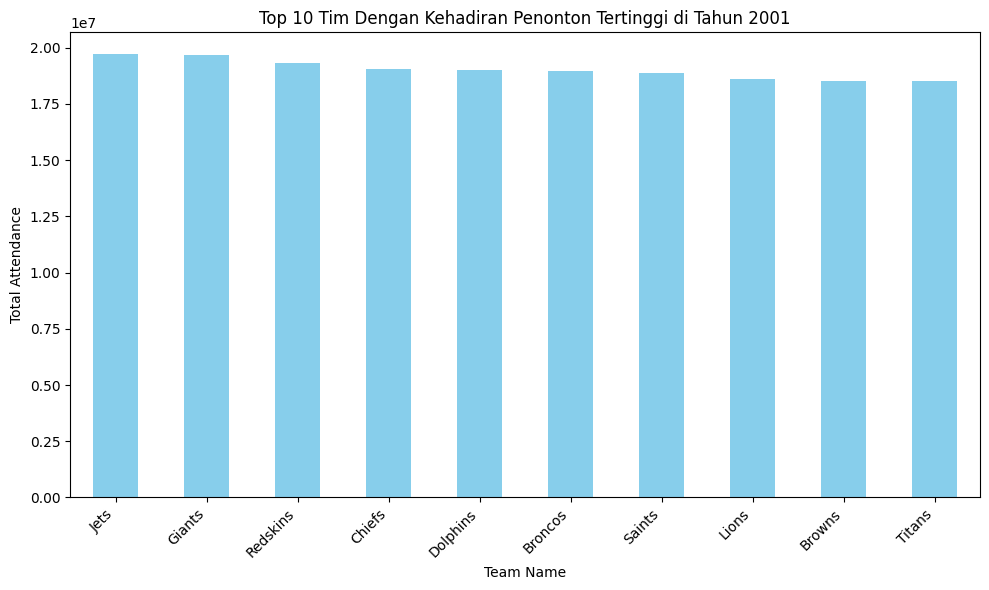

In [11]:
df_2001 = df[df['year'] == 2001]
top_10_teams = df_2001.groupby('team_name')['total'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_teams.plot(kind='bar', color='skyblue')
plt.title('Top 10 Tim Dengan Kehadiran Penonton Tertinggi di Tahun 2001')
plt.xlabel('Team Name')
plt.ylabel('Total Attendance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Dari grafik line chart, dibuatlah grafik untuk melihat 10 top tim di tahun dengan kehadiran penonton tertinggi sepanjang liga

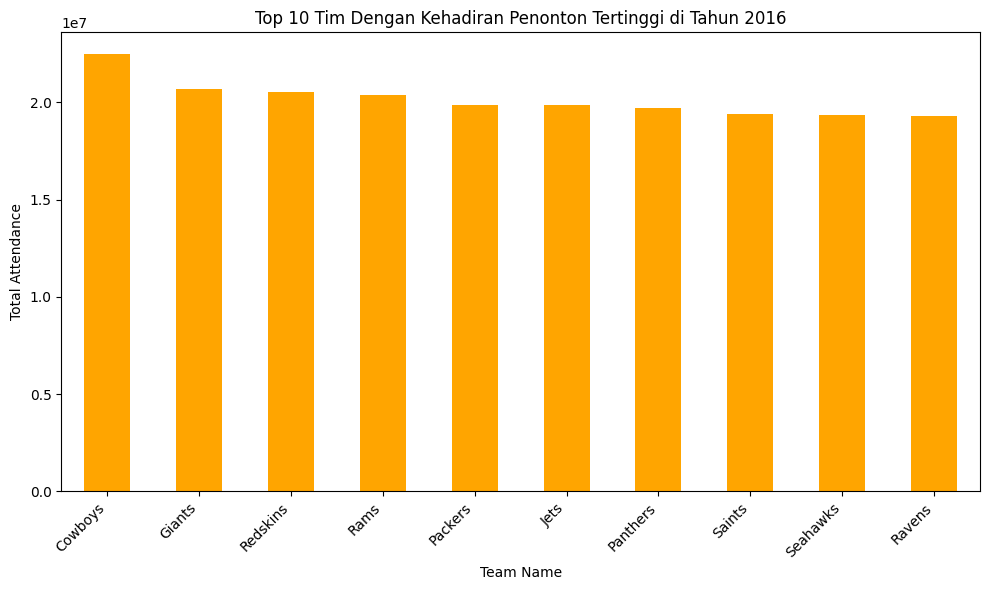

In [12]:
df_2016 = df[df['year'] == 2016]
top_10_teams = df_2016.groupby('team_name')['total'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_teams.plot(kind='bar', color='orange')
plt.title('Top 10 Tim Dengan Kehadiran Penonton Tertinggi di Tahun 2016')
plt.xlabel('Team Name')
plt.ylabel('Total Attendance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Terakhir dibuat grafik untuk melihat 10 top tim di tahun terbaru dalam data liga NFL, untuk melihat tim dengan popularitas yang masih bertahan setelah 20 tahun (2000-2019)

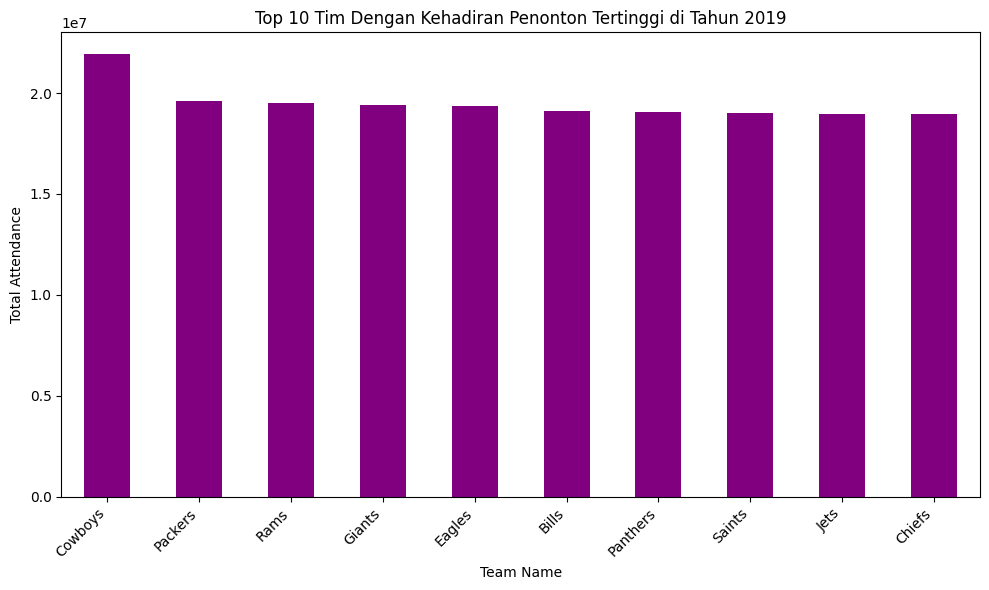

In [13]:
df_2001 = df[df['year'] == 2019]
top_10_teams = df_2001.groupby('team_name')['total'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10_teams.plot(kind='bar', color='purple')
plt.title('Top 10 Tim Dengan Kehadiran Penonton Tertinggi di Tahun 2019')
plt.xlabel('Team Name')
plt.ylabel('Total Attendance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Grafik perbandingan top tim pertama di tahun dengan kehadiran tertinggi vs. terendah, untuk melihat perbandingan jumlah penonton di tahun terbaru data NFL (2019)

Total attendance for Cowboys in 2019: 21913459
Total attendance for Jets in 2019: 18984087
Attendance difference between Cowboys and Jets in 2019: 2929372


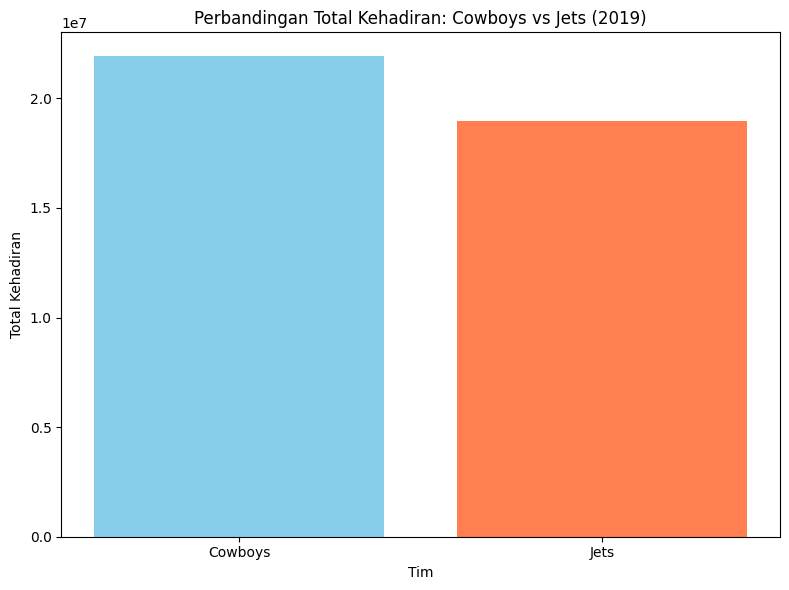

In [14]:
df_2019 = df[(df['year'] == 2019) & (df['team_name'].isin(['Cowboys', 'Jets']))]
attendance_2019_total = df_2019.groupby('team_name')['total'].sum().reset_index()
cowboys_attendance = attendance_2019_total.loc[attendance_2019_total['team_name'] == 'Cowboys', 'total'].values[0]
jets_attendance = attendance_2019_total.loc[attendance_2019_total['team_name'] == 'Jets', 'total'].values[0]
attendance_difference = abs(cowboys_attendance - jets_attendance)

print(f"Total attendance for Cowboys in 2019: {cowboys_attendance}")
print(f"Total attendance for Jets in 2019: {jets_attendance}")
print(f"Attendance difference between Cowboys and Jets in 2019: {attendance_difference}")

plt.figure(figsize=(8, 6))
plt.bar(attendance_2019_total['team_name'], attendance_2019_total['total'], color=['skyblue', 'coral'])
plt.xlabel('Tim')
plt.ylabel('Total Kehadiran')
plt.title('Perbandingan Total Kehadiran: Cowboys vs Jets (2019)')
plt.tight_layout()
plt.show()

Grafik mingguan, untuk melihat perbandingan pola kehadiran penonton cowboys vs jets di tahun 2019

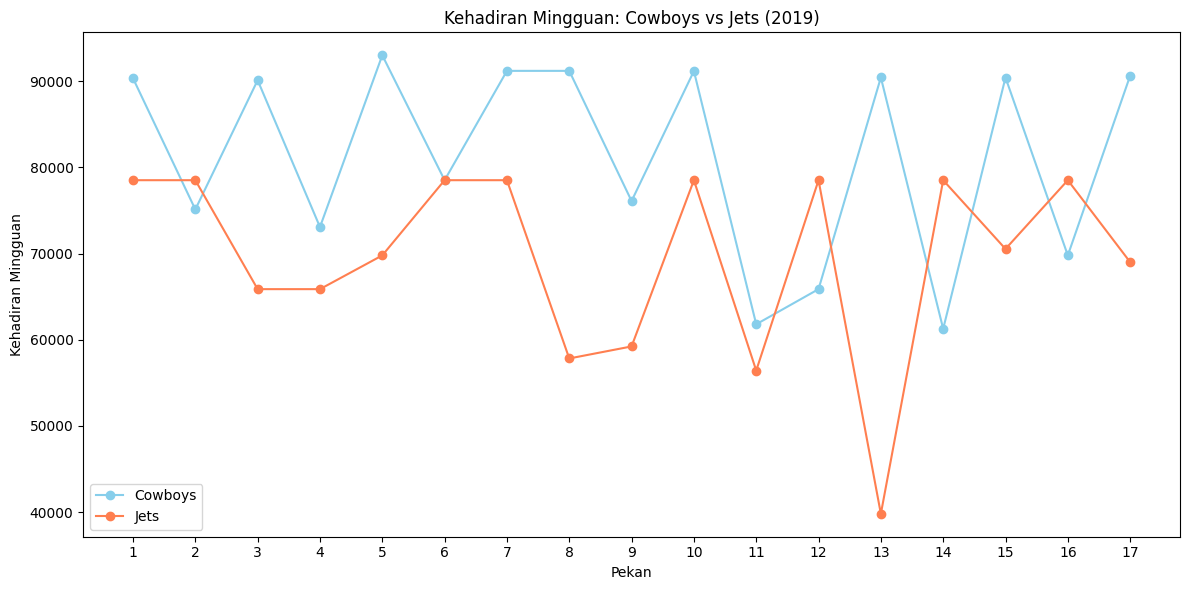

In [15]:
df_2019 = df[(df['year'] == 2019) & (df['team_name'].isin(['Cowboys', 'Jets']))]
attendance_weekly = df_2019.groupby(['team_name', 'week'])['weekly_attendance'].sum().reset_index()

plt.figure(figsize=(12, 6))

cowboys_data = attendance_weekly[attendance_weekly['team_name'] == 'Cowboys']
plt.plot(cowboys_data['week'], cowboys_data['weekly_attendance'], label='Cowboys', color='skyblue', marker='o')

jets_data = attendance_weekly[attendance_weekly['team_name'] == 'Jets']
plt.plot(jets_data['week'], jets_data['weekly_attendance'], label='Jets', color='coral', marker='o')

plt.xlabel('Pekan')
plt.ylabel('Kehadiran Mingguan')
plt.title('Kehadiran Mingguan: Cowboys vs Jets (2019)')
plt.xticks(range(1, 18))
plt.legend()
plt.tight_layout()
plt.show()

Dari grafik sebelumnya top tim pertama di tahun dengan penonton terendah, dibuat grafik linechart untuk melihat pola popularitas tim Jets

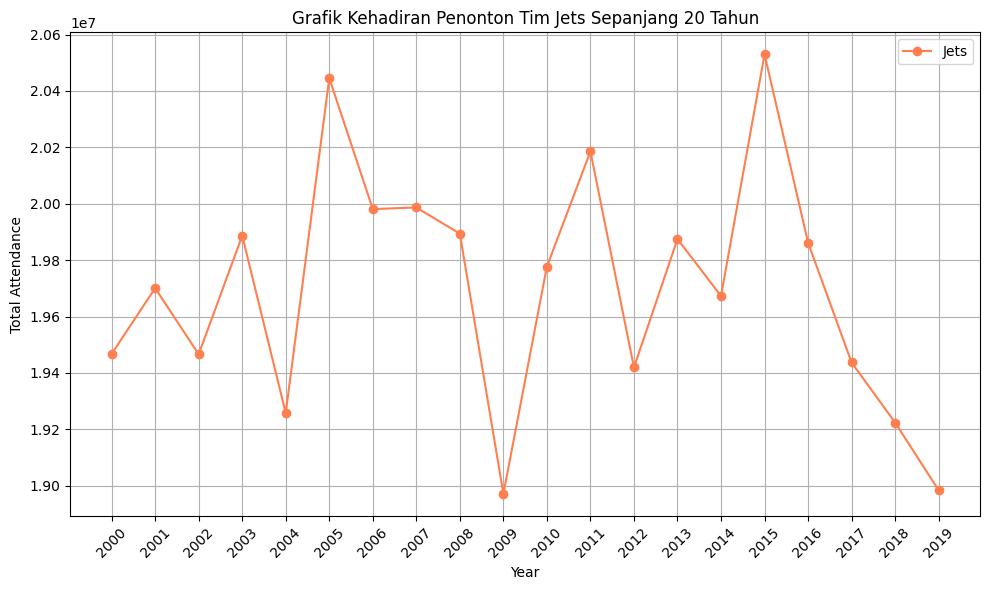

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

cowboys_data = df[df['team_name'] == 'Jets']

cowboys_yearly_attendance = cowboys_data.groupby('year')['total'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(cowboys_yearly_attendance['year'],
         cowboys_yearly_attendance['total'],
         marker='o', color='coral', label='Jets')

plt.title('Grafik Kehadiran Penonton Tim Jets Sepanjang 20 Tahun')
plt.xlabel('Year')
plt.ylabel('Total Attendance')
plt.xticks(cowboys_yearly_attendance['year'], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Dari grafik sebelumnya top tim pertama di tahun dengan penonton tertinggi, dibuat grafik linechart untuk melihat pola popularitas tim Cowboys

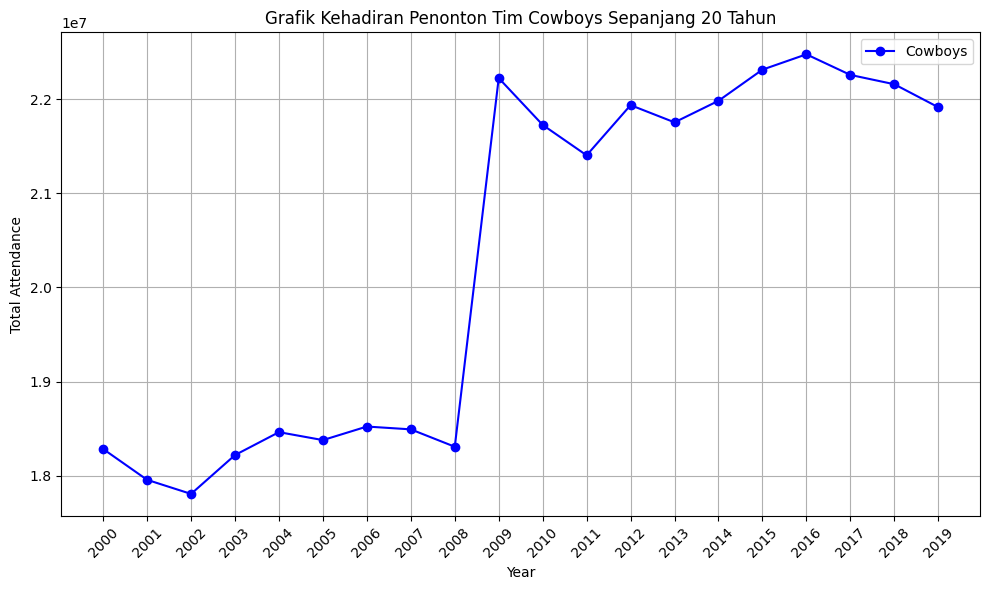

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

cowboys_data = df[df['team_name'] == 'Cowboys']

cowboys_yearly_attendance = cowboys_data.groupby('year')['total'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(cowboys_yearly_attendance['year'],
         cowboys_yearly_attendance['total'],
         marker='o', color='blue', label='Cowboys')

plt.title('Grafik Kehadiran Penonton Tim Cowboys Sepanjang 20 Tahun')
plt.xlabel('Year')
plt.ylabel('Total Attendance')
plt.xticks(cowboys_yearly_attendance['year'], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
